Pierre Nikitits
## Course Project: Electricity Price Explanation

Dataset:

- Consumption
- Exchange
- Net Export/Import
- Energy Sources
- Residual Load
- Weather Conditions
- Market Dynamics

Steps:

1. Preprocessing Data
2. Metric definition
3. Define models: Random Forest, Linear Regression, SVR, XGboost
4. Hyperparameter Tuning: Optuna search
5. Evaluation
6. Interpretation

## Loading and Preprocessing the data

In [1]:
import pandas as pd
path = "/Users/pierre/Documents/GitHub/EnsembleLearningProject/Data/"

X_train = pd.read_csv(path + 'X_train.csv').set_index('ID')
y_train = pd.read_csv(path + 'y_train.csv').set_index('ID')
X_test = pd.read_csv(path + 'X_test.csv').set_index('ID')
y_test = pd.read_csv(path + 'y_test.csv').set_index('ID')

In [2]:
print("X_train :" , X_train.shape)
print("y_train :" , y_train.shape)

print("\nX_test  :" , X_test.shape)
print("y_test  :" , y_test.shape)

X_train : (1494, 34)
y_train : (1494, 1)

X_test  : (654, 34)
y_test  : (654, 1)


In [3]:
X_train.drop(columns=['COUNTRY' , 'DAY_ID'], inplace=True)
X_test.drop(columns=['COUNTRY' , 'DAY_ID'], inplace=True)

In [4]:
X_train.head()

,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
ID,,,,,,,,,,,,,,,,,,,,,
1054,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,-0.692860,0.441238,-0.213766,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
2049,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,1.130838,0.174773,0.426940,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
1924,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,1.682587,2.351913,2.122241,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
297,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,-0.563230,0.487818,0.194659,...,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
1101,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,-0.990324,0.238693,-0.240862,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378


In [5]:
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

In [6]:
print(X_train.shape)
print(y_train.shape)

(1276, 32)
(1276, 1)


## Metrics
- Mean Squared Error
- Root Mean Squared Error
- Mean Absolute Error
- R-squared
- Mean Absolute Percentage Error

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score , mean_absolute_percentage_error , log_loss
from math import sqrt

def find_metrics(y_test_values , predicted_values):
    mse = mean_squared_error(y_test_values, predicted_values)
    print("Mean Squared Error:", mse)

    rmse = sqrt(mean_squared_error(y_test_values, predicted_values))
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    mae = mean_absolute_error(y_test_values, predicted_values)
    print(f"Mean Absolute Error (MAE): {mae}")

    r2 = r2_score(y_test_values, predicted_values)
    print(f"R-squared (R²): {r2}")

    mape = mean_absolute_percentage_error(y_test_values, predicted_values)
    print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

## Models Definitions

1. Random Forest
2. Linear Regression
3. SVR
4. XGboost

## 1. Random Forest

In [23]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape_error
import logging
logging.getLogger("optuna").setLevel(logging.WARNING)



def objective_rand_forest(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 200, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 11)
    min_samples_split = trial.suggest_int('min_samples_split', 4, 11)

    
    random_forest = RandomForestRegressor(
        random_state=11,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split
    )
    
    random_forest.fit(X_train, y_train.values.ravel())
    pred = random_forest.predict(X_test)

    
    error = mean_squared_error(y_test, pred) # mape_error

    trial.report(error, step=0)

    if trial.should_prune():
        raise optuna.TrialPruned()

    return error


pruner = optuna.pruners.MedianPruner()


study_rand_forest = optuna.create_study(direction='minimize',
                            pruner=pruner,
                            study_name="random_forest_study",
                            storage='sqlite:///random_forest_study.db',
                            load_if_exists=True)

study_rand_forest.optimize(objective_rand_forest, n_trials=100 , n_jobs=-1)

print(f"Best trial: {study_rand_forest.best_trial}")
print(f"Best parameters: {study_rand_forest.best_params}")
print(f"Best value (mape_error): {study_rand_forest.best_value}")

Best trial: FrozenTrial(number=58, state=1, values=[1.1075111026675244], datetime_start=datetime.datetime(2024, 3, 4, 23, 40, 28, 309959), datetime_complete=datetime.datetime(2024, 3, 4, 23, 40, 40, 569038), params={'n_estimators': 951, 'max_depth': 2, 'min_samples_split': 8}, user_attrs={}, system_attrs={}, intermediate_values={0: 1.1075111026675244}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=200, step=1), 'max_depth': IntDistribution(high=11, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=11, log=False, low=4, step=1)}, trial_id=59, value=None)
Best parameters: {'n_estimators': 951, 'max_depth': 2, 'min_samples_split': 8}
Best value (mape_error): 1.1075111026675244


In [24]:
random_forest = RandomForestRegressor(random_state=11 , n_estimators=951 , max_depth=2 , min_samples_split=8)
random_forest.fit(X_train, y_train.values.ravel())

random_forest_pred = random_forest.predict(X_test)
find_metrics(y_test['TARGET'].values , random_forest_pred)


Mean Squared Error: 1.1075111026675244
Root Mean Squared Error (RMSE): 1.0523835340157714
Mean Absolute Error (MAE): 0.8470036901600647
R-squared (R²): -0.05463350213962337
Mean Absolute Percentage Error (MAPE): 2.373692088181954%


In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

pipeline = make_pipeline(
    KNNImputer(),
    RFE(estimator=RandomForestRegressor(random_state=11 , n_estimators=951 , max_depth=2 , min_samples_split=8), n_features_to_select=10),
)

pipeline.fit(X_train, y_train.values.ravel())
pipeline_pred = pipeline.predict(X_test)


find_metrics(y_test['TARGET'].values, pipeline_pred)


Mean Squared Error: 1.1107968054947703
Root Mean Squared Error (RMSE): 1.053943454600279
Mean Absolute Error (MAE): 0.847125947351596
R-squared (R²): -0.05776233061939395
Mean Absolute Percentage Error (MAPE): 2.5435811951508183%


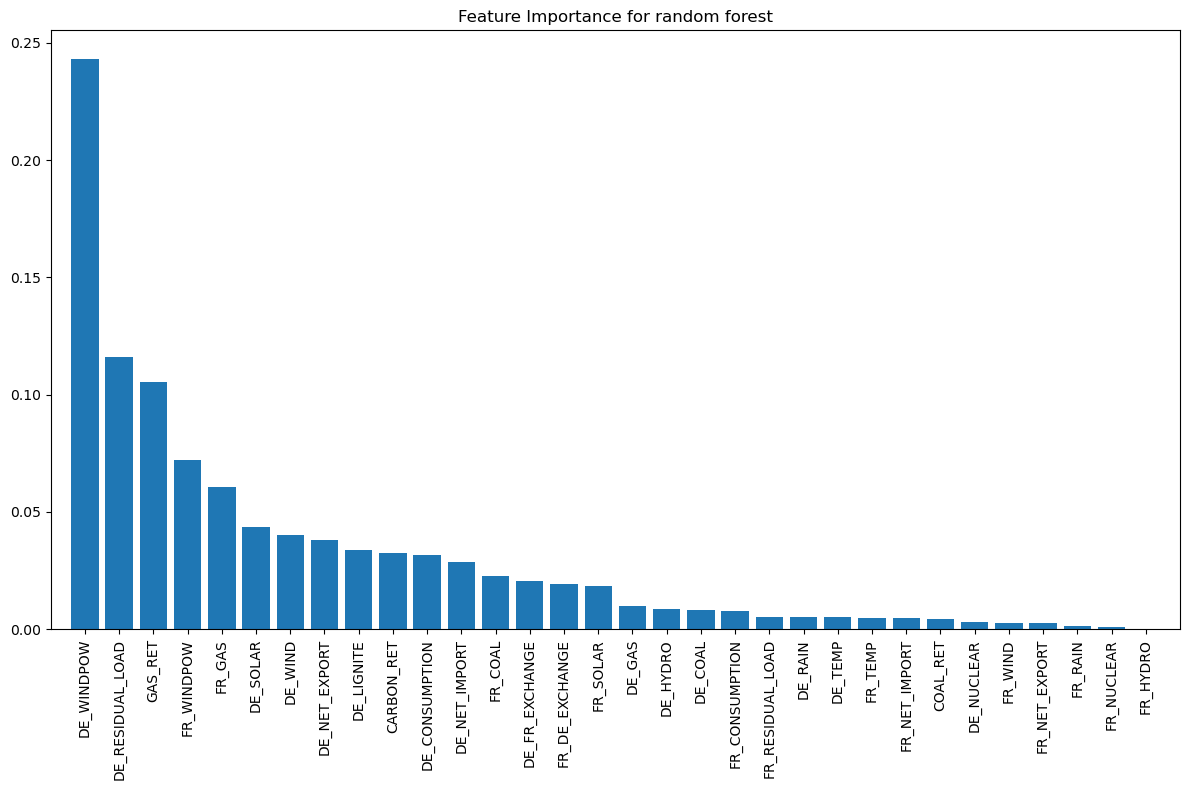

In [10]:
import numpy as np
import matplotlib.pyplot as plt


feature_importances = random_forest.feature_importances_
feature_names = X_train.columns
sorted_indices = np.argsort(feature_importances)[::-1]


plt.figure(figsize=(12, 8))
plt.title("Feature Importance for random forest")
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align="center")
plt.xticks(range(len(feature_importances)), feature_names[sorted_indices], rotation=90)
plt.xlim([-1, len(feature_importances)])
plt.tight_layout()
plt.show()

## 2. Linear Regression

In [11]:
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train.values.ravel())

linear_pred = linear_regression.predict(X_test)
find_metrics(y_test , linear_pred)

Mean Squared Error: 1.1518256780029095
Root Mean Squared Error (RMSE): 1.0732314186618417
Mean Absolute Error (MAE): 0.8674191694960335
R-squared (R²): -0.09683229876497612
Mean Absolute Percentage Error (MAPE): 2.7917000979889517%


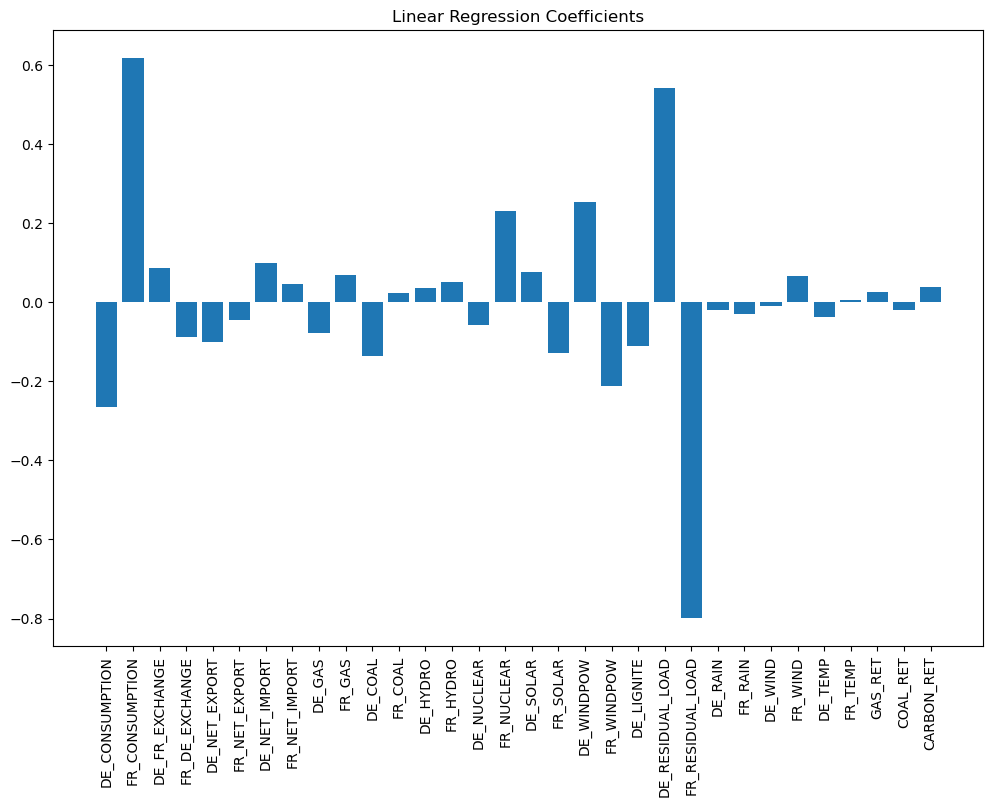

In [12]:
coefficients = linear_regression.coef_
feature_names = X_train.columns

plt.figure(figsize=(12, 8))
plt.bar(feature_names, coefficients)
plt.xticks(rotation=90)
plt.title("Linear Regression Coefficients")
plt.show()

## 3. SVR

In [27]:
from sklearn.svm import SVR


def objective_svr(trial):
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    C = trial.suggest_float('C', 0.1, 1)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    svr = SVR(kernel=kernel , C=C , gamma=gamma)
    svr.fit(X_train, y_train.values.ravel())
    svr_pred = svr.predict(X_test)

    error = mean_squared_error(y_test, svr_pred)
    return error

svr_study = optuna.create_study(direction='minimize',
                            study_name="svr_study",
                            storage='sqlite:///svr_study.db',
                            load_if_exists=True)

svr_study.optimize(objective_svr, n_trials=1000 , n_jobs=-1)

print(f"Best trial: {svr_study.best_trial}")
print(f"Best parameters: {svr_study.best_params}")
print(f"Best value (mse_error): {svr_study.best_value}")

Best trial: FrozenTrial(number=943, state=1, values=[1.0685552185154126], datetime_start=datetime.datetime(2024, 3, 4, 23, 55, 14, 483018), datetime_complete=datetime.datetime(2024, 3, 4, 23, 55, 14, 872529), params={'kernel': 'rbf', 'C': 0.10005410447879137, 'gamma': 'auto'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'kernel': CategoricalDistribution(choices=('linear', 'rbf')), 'C': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'gamma': CategoricalDistribution(choices=('scale', 'auto'))}, trial_id=944, value=None)
Best parameters: {'kernel': 'rbf', 'C': 0.10005410447879137, 'gamma': 'auto'}
Best value (mape_error): 1.0685552185154126


In [28]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf' , C=0.10005410447879137 , gamma='auto')
svr.fit(X_train, y_train.values.ravel())

svr_pred = svr.predict(X_test)
find_metrics(y_test , svr_pred)

Mean Squared Error: 1.0685552185154126
Root Mean Squared Error (RMSE): 1.0337094458867118
Mean Absolute Error (MAE): 0.8296562269765034
R-squared (R²): -0.017537548488835597
Mean Absolute Percentage Error (MAPE): 1.7102541671138225%


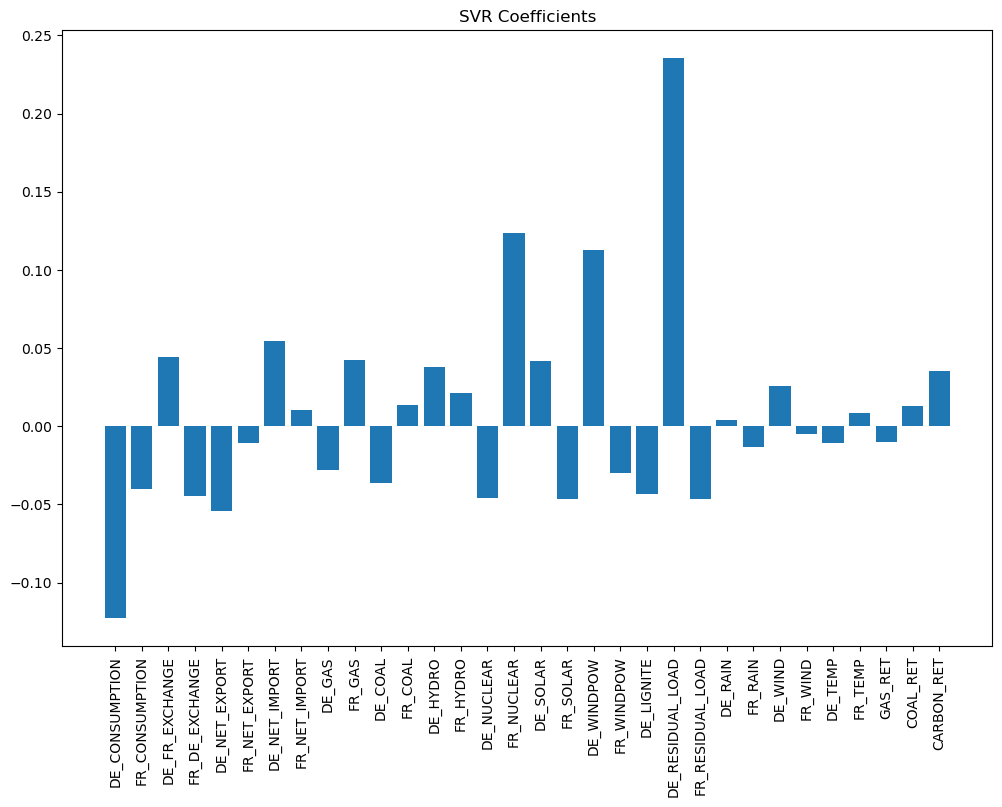

In [15]:
coefficients = svr.coef_.flatten()

plt.figure(figsize=(12, 8))
plt.bar(feature_names, coefficients)
plt.xticks(rotation=90)
plt.title("SVR Coefficients")
plt.show()

## 4. XGboost

In [29]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


def objective_xgb(trial):
    max_depth = trial.suggest_int('max_depth', 3, 10)
    eta = trial.suggest_float('eta', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    lambda_reg = trial.suggest_float('lambda', 1e-8, 10.0)
    alpha = trial.suggest_float('alpha', 1e-8, 10.0)

    params = {
        'max_depth': max_depth,
        'eta': eta,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'lambda': lambda_reg,
        'alpha': alpha,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse'
    }
    num_round = 100
    bst = xgb.train(params, dtrain, num_round)
    preds = bst.predict(dtest)
    
    cv_results = xgb.cv(params, dtrain, num_boost_round=100, nfold=3,
                        early_stopping_rounds=10,
                        metrics="rmse", as_pandas=True, seed=11)
    

    bst = xgb.train(params, dtrain, num_boost_round=cv_results.shape[0])
    preds = bst.predict(dtest)
    error = mean_squared_error(y_test, preds)
    return error


xgb_study = optuna.create_study(direction='minimize',
                            study_name="xgb_study",
                            storage='sqlite:///xgb_study.db',
                            load_if_exists=True)

xgb_study.optimize(objective_xgb, n_trials=100 , n_jobs=-1)

print(f"Best trial: {xgb_study.best_trial}")
print(f"Best parameters: {xgb_study.best_params}")
print(f"Best value (mse_error): {xgb_study.best_value}")

Best trial: FrozenTrial(number=85, state=1, values=[1.0550364690797769], datetime_start=datetime.datetime(2024, 3, 5, 0, 1, 31, 698540), datetime_complete=datetime.datetime(2024, 3, 5, 0, 1, 38, 441939), params={'max_depth': 10, 'eta': 0.0900016273293135, 'subsample': 0.7097078664524397, 'colsample_bytree': 0.8548377681014026, 'lambda': 6.520067097378993, 'alpha': 0.4381539710613589}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'eta': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'lambda': FloatDistribution(high=10.0, log=False, low=1e-08, step=None), 'alpha': FloatDistribution(high=10.0, log=False, low=1e-08, step=None)}, trial_id=86, value=None)
Best parameters: {'max_depth': 10, 'eta': 0.0900016273293135, 'subsample': 0.7097078

In [31]:
params = {
        'max_depth': 10,
        'eta': 0.0900016273293135,
        'subsample': 0.7097078664524397,
        'colsample_bytree': 0.8548377681014026,
        'lambda': 6.520067097378993,
        'alpha': 0.4381539710613589,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse'
    }

bst = xgb.train(params, dtrain , 100)
xgb_preds = bst.predict(dtest)



find_metrics(y_test , xgb_preds)

1.2006193528646103
Mean Squared Error: 1.2006193528646103
Root Mean Squared Error (RMSE): 1.0957277731556367
Mean Absolute Error (MAE): 0.8802795919462292
R-squared (R²): -0.14329634240093947
Mean Absolute Percentage Error (MAPE): 4.087956345301701%


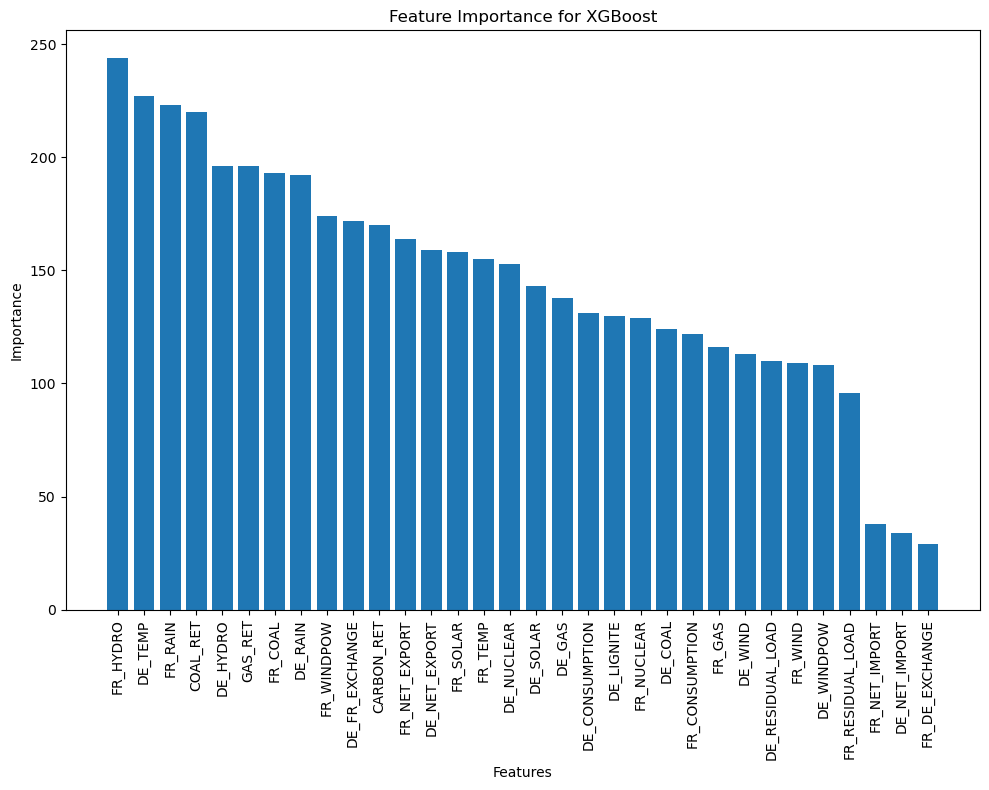

In [19]:
importances = bst.get_score(importance_type='weight')


sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)
features, importance_scores = zip(*sorted_importances)


plt.figure(figsize=(10, 8))
plt.bar(features, importance_scores)
plt.ylabel('Importance')
plt.xlabel('Features')
plt.title('Feature Importance for XGBoost')
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()
